# Predictive Model 

- Create a new column `is_obese` that checks whether someone is obese or not
- predict  `is_obese` using RandomForestClassifier 

# Model

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
import pickle

df = pd.read_csv('clean_llcp2021.csv')

# Drop misc. values
df = df[(df['EXERANY2'] != 'BLANK')
      & (df['ASTHMA3'] != 'Not Sure') & (df['ASTHMA3'] != 'Refused')
      & (df['HAVARTH5'] != 'Not Sure') & (df['HAVARTH5'] != 'Refused')
      & (df['RENTHOM1'] != 'BLANK')
      & (df['_MICHD'] != 'BLANK')
      & (df['PRIMINSR'] != 'BLANK')]

df.drop(columns = 'Division', inplace = True)

In [2]:
# Binary Encoding: 'EXERANY2', 'ASTHMA3', 'HAVARTH5', '_MICHD', '_HISPANC', '_SEX'
for col in ['EXERANY2', 'ASTHMA3', 'HAVARTH5', '_MICHD']:
    df[col] = df[col].eq('Yes').mul(1)
df['_HISPANC'] = df['_HISPANC'].eq('Hispanic, Latino/a, or Spanish origin').mul(1)
df['_SEX'] = df['_SEX'].eq('Female').mul(1)
# One Hot Encoding: 'PRIMINSR', 'RENTHOM1', '_PRACE1', 'Region'
df = pd.get_dummies(df, columns = ['PRIMINSR', 'RENTHOM1', '_PRACE1', 'Region'])
# Ordinal Encoding: 'INCOME3', '_AGEG5YR', '_EDUCAG'
enc = OrdinalEncoder(categories=[['Less than $10,000',
                                  '$10,000 to < $15,000',
                                  '$15,000 to < $20,000',
                                  '$20,000 to < $25,000',
                                  '$25,000 to < $35,000',
                                  '$35,000 to < $50,000',
                                  '$50,000 to < $75,000',
                                  '$75,000 to < $100,000',
                                  '$100,000 to < $150,000',
                                  '$150,000 to < $200,000',
                                  '$200,000 or more']])
enc.fit(pd.DataFrame(df['INCOME3']))
df['INCOME3'] = enc.transform(pd.DataFrame(df['INCOME3']))
enc = OrdinalEncoder(categories=[['Age 18 to 24',
                                  'Age 25 to 29',
                                  'Age 30 to 34',
                                  'Age 35 to 39',
                                  'Age 40 to 44',
                                  'Age 45 to 49',
                                  'Age 50 to 54',
                                  'Age 55 to 59',
                                  'Age 60 to 64',
                                  'Age 65 to 69',
                                  'Age 70 to 74',
                                  'Age 75 to 79',
                                  'Age 80 or older']])
enc.fit(pd.DataFrame(df['_AGEG5YR']))
df['_AGEG5YR'] = enc.transform(pd.DataFrame(df['_AGEG5YR']))
enc = OrdinalEncoder(categories=[['Did not graduate High School',
                                  'Graduated High School',
                                  'Attended College or Technical School',
                                  'Graduated from College or Technical School']])
enc.fit(pd.DataFrame(df['_EDUCAG']))
df['_EDUCAG'] = enc.transform(pd.DataFrame(df['_EDUCAG']))

# Random Forest

In [24]:
def get_cm_plot(actual_y, predicted_y, labels):
    cm = metrics.confusion_matrix(actual_y, predicted_y, labels = labels)

    ax= plt.subplot()
    sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

    # labels, title and ticks
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')
    ax.xaxis.set_ticklabels(['Not Obese', 'Obese'])
    ax.yaxis.set_ticklabels(['Not Obese', 'Obese'])

def plot_feature_imp(model, type_model, feature_names):
    importances = model.feature_importances_
    std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)

    forest_importances = pd.Series(importances, index=feature_names)

    indices = np.argsort(forest_importances)
    plt.figure(figsize=(8,12))
    plt.title(f'Feature Importances {type_model}')
    plt.barh(range(len(indices)), importances[indices], color='b', align='center')
    plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.show()


### RandomForestClassifier

In [4]:
df["is_obese"] = np.where(df["_BMI5CAT"] == 4,1,0)

In [11]:
df[['_BMI5CAT']].groupby(['_BMI5CAT']).size()

_BMI5CAT
1.0      4233
2.0     85024
3.0    106912
4.0    104259
dtype: int64

In [5]:
X, y = df.drop(columns=["_BMI5", "_BMI5CAT","is_obese"]), df["is_obese"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)


In [6]:
df = df.rename(columns={"PHYSHLTH": "Physical Health",
                        "MENTHLTH": "Mental Health",
                        "EXERANY2": "Exercise",
                        "ASTHMA3": "Asthma",
                        "HAVARTH5": "Arthritis",
                        "INCOME3": "Income",
                        "_MICHD": "Heart Attack",
                        "_HISPANC": "Hispanic",
                        "_SEX": "Sex",
                        "_AGEG5YR": "Age",
                        "_BMI5": "BMI",
                        "_CHLDCNT": "Number of Children",
                        "_EDUCAG": "Education",
                        "_DRNKWK1": "Alcohol Consumption",
                        "FTJUDA2_": "Fruit Juice Intake",
                        "FRUTDA2_": "Fruit Intake",
                        "GRENDA1_": "Dark Green Vegetable Intake",
                        "FRNCHDA_": "French Fry Intake",
                        "POTADA1_": "Potato Intake",
                        "VEGEDA2_": "Other Vegetable Intake",
                        "No_lean": "No Lean",
                        'PRIMINSR_Children Health Insurance Program': "Health Insurance: CHIP",
                        'PRIMINSR_Employer': "Health Insurance: Employer",
                        'PRIMINSR_Indian Health Service': "Health Insurance: Indian Health Service",
                        'PRIMINSR_Medicaid': "Health Insurance: Medicaid",
                        'PRIMINSR_Medicare': "Health Insurance: Medicare",
                        'PRIMINSR_Medigap': "Health Insurance: Medigap",
                        'PRIMINSR_Military': "Health Insurance: Military",
                        'PRIMINSR_No coverage': "Health Insurance: No Coverage",
                        'PRIMINSR_Other government': "Health Insurance: Other Govt Program",
                        'PRIMINSR_Private': "Health Insurance: Private",
                        'PRIMINSR_State sponsored': "Health Insurance: State-Sponsored",
                        'RENTHOM1_Other': "Rent Home: Other",
                        'RENTHOM1_Own': "Rent Home: Own",
                        'RENTHOM1_Rent': "Rent Home: Rent",
                        '_PRACE1_American Indian or Alaskan Native': "Race: American Indian or Alaskan Native",
                        '_PRACE1_Asian': "Race: Asian",
                        '_PRACE1_Black or African American': "Race: Black or African American",
                        '_PRACE1_Multiracial but preferred race not answered': "Race: Multiracial",
                        '_PRACE1_Native Hawaiian or other Pacific Islander': "Race: Pacific Islander",
                        '_PRACE1_No preferred race': "Race: No Preferred",
                        '_PRACE1_Other race': "Race: Other",
                        '_PRACE1_White': "Race: White",
                        'Region_Midwest': "Region: Midwest",
                        'Region_Northeast': "Region: Northeast",
                        'Region_Puerto Rico': "Region: Puerto Rico",
                        'Region_South': "Region: South",
                        'Region_Virgin Islands': "Region: Virgin Islands",
                        'Region_West': "Region: West"})

In [12]:
pd.DataFrame(y).groupby(['is_obese']).size()

is_obese
0    196169
1    104259
dtype: int64

In [13]:
base_model_classifier = RandomForestClassifier(random_state = 0)
base_model_classifier.fit(X_train, y_train)
y_pred = base_model_classifier.predict(X_test)

print('Model accuracy score: {0:0.4f}'.format(accuracy_score(y_test, y_pred)))

Model accuracy score: 0.6723


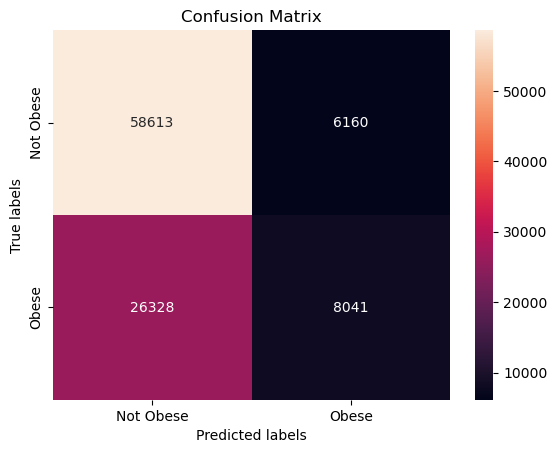

In [25]:
get_cm_plot(y_test, y_pred, base_model_classifier.classes_)

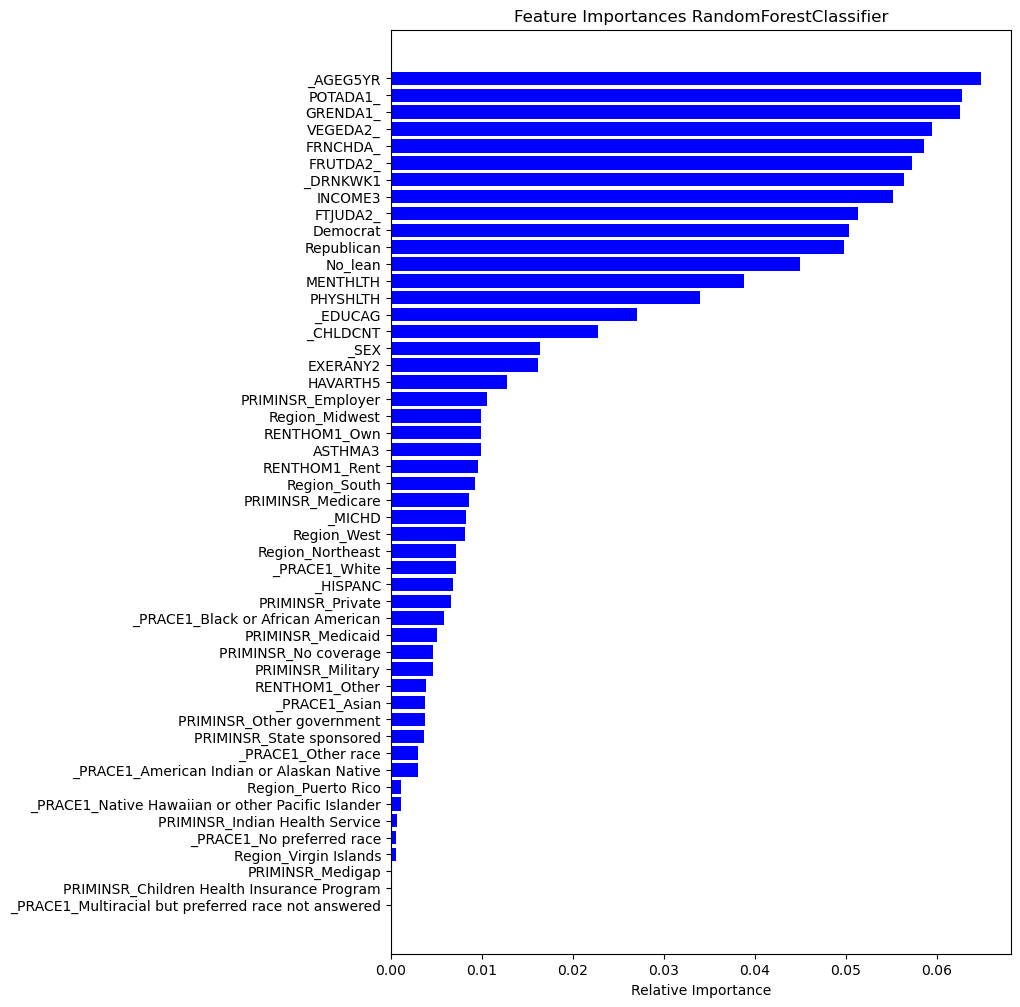

In [22]:
plot_feature_imp(base_model_classifier, "RandomForestClassifier", X_train.columns)

In [18]:
28126/(28126+471+6714)

0.7965223301520773

In [26]:
pkl_filename = "rf_base_model_2classes.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(base_model_classifier, file)

#### Hyperparameter tuning

In [27]:
clf = RandomForestClassifier( random_state = 0)

param_grid = {
    'n_estimators': [200, 500, 800, 1000],
    'max_depth': [10, 25, 50, None],
}

grid_clf = GridSearchCV(clf, param_grid, cv=5)
grid_clf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=0),
             param_grid={'max_depth': [10, 25, 50, None],
                         'n_estimators': [200, 500, 800, 1000]})

In [28]:
grid_clf.best_params_

{'max_depth': 25, 'n_estimators': 1000}

In [29]:
best_random_classifier = grid_clf.best_estimator_
y_pred = best_random_classifier.predict(X_test)

print('Model accuracy score: {0:0.4f}'.format(accuracy_score(y_test, y_pred)))

Model accuracy score: 0.6762


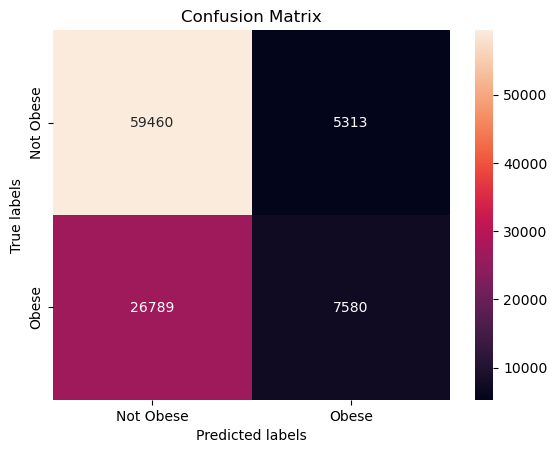

In [30]:
get_cm_plot(y_test, y_pred, best_random_classifier.classes_)

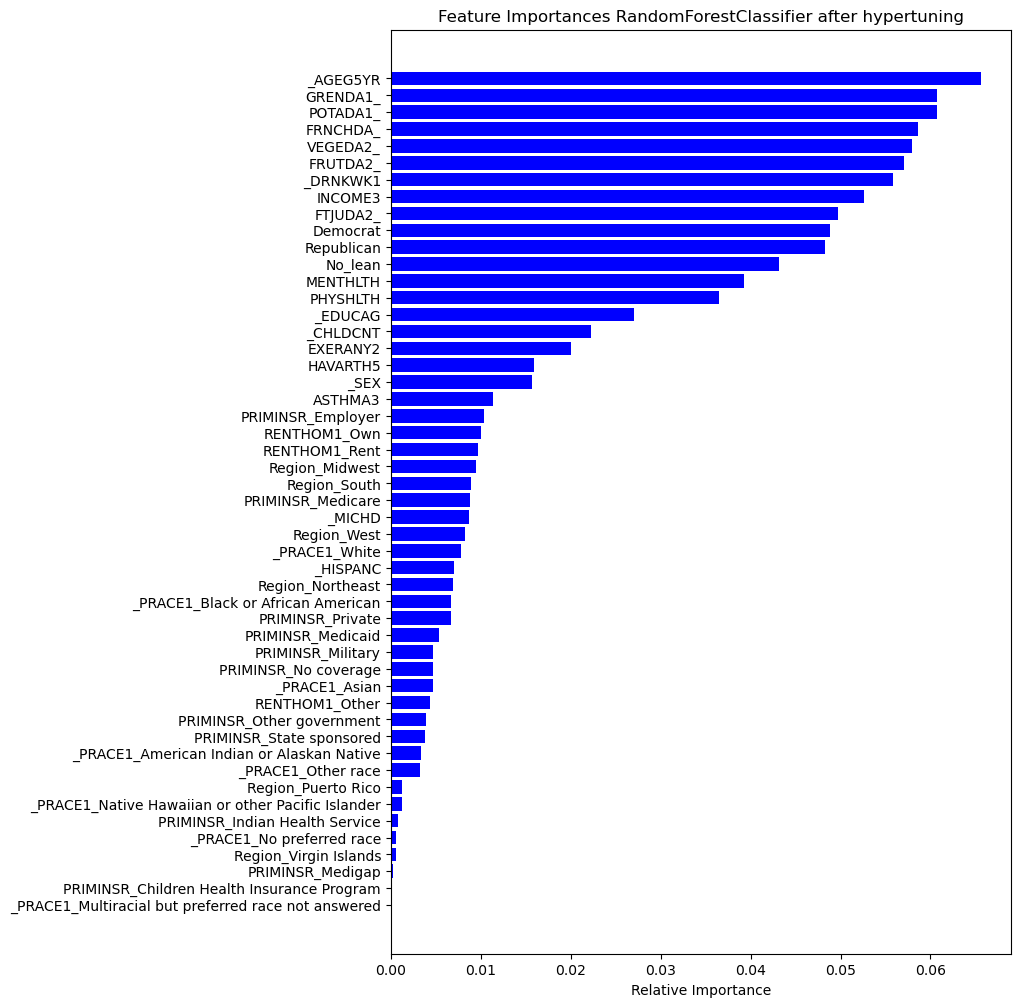

In [31]:
plot_feature_imp(best_random_classifier, "RandomForestClassifier after hypertuning", X_train.columns)

In [32]:
# Save the model under the cwd
pkl_filename = "rf_grid_base_2classes.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(grid_clf, file)

In [33]:
# Save the model under the cwd
pkl_filename = "rf_best_2classes.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(best_random_classifier, file)

In [34]:
def get_sensitivity(actual_y, predicted_y):
    cm = metrics.confusion_matrix(actual_y, predicted_y, labels = best_random_classifier.classes_)
    for i in range(len(cm)):
        sum_i = sum(cm[i])
        for j in range(len(cm)):
            if i == j:
                print(i, cm[i][j]/sum_i*100)

get_sensitivity(y_test, y_pred)

0 91.79750822101802
1 22.054758648782332
